In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas_profiling import ProfileReport
import json
import pickle
import requests
from scipy.stats import pearsonr

In [29]:
EPC = pd.read_csv('../data/processed/EPC_elec_consump_fuel_poverty.csv') # loading the dataframe
if 'Unnamed: 0' in EPC.columns:
    EPC.drop('Unnamed: 0', inplace=True, axis=1)
print(EPC.columns[0])

low-energy-fixed-light-count


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas_profiling/model/correlations.py:61: UserWarning: There was an attempt to calculate the cramers correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"cramers": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'No data; `observed` has size 0.')
  (include the error message: '{error}')"""
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/missingno/missingno.py:255: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.get_xticklabels(), rotation=label_rotation, ha='right', fontsize=fontsize
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas_profiling/model/missing.py:95: UserWarning: There was an attempt to generate the C

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

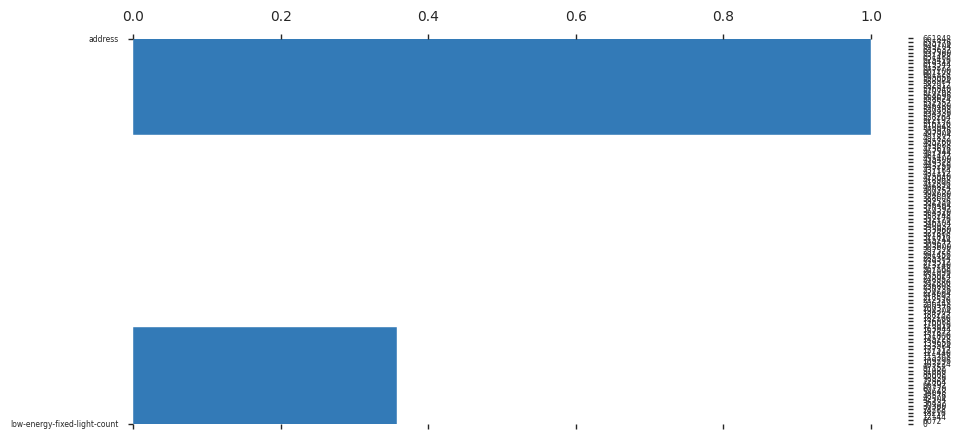

In [30]:
# performing the pandas profiling on the data
EPC_profile = ProfileReport(EPC, title="EPC Profile Report {0} Homes".format(len(EPC)), explorative=True)

# saving results to html
EPC_profile.to_file('../outputs/pandas_profiling_{0}_homes.html'.format(len(EPC)))

In [31]:
profile = EPC_profile.description_set # grabbing descriptive set
profile.keys()

dict_keys(['analysis', 'table', 'variables', 'scatter', 'correlations', 'missing', 'alerts', 'package', 'sample', 'duplicates'])

In [184]:
profile['table']
profile['correlations']['phi_k']['current-energy-efficiency'].sort_values(ascending=False)

current-energy-efficiency      1.000000
current-energy-rating          0.917242
potential-energy-efficiency    0.858448
address3                       0.853199
environment-impact-current     0.820061
                                 ...   
photo-supply                   0.111891
uprn-source                    0.100287
posttown                       0.097359
building-reference-number      0.070464
solar-water-heating-flag       0.000000
Name: current-energy-efficiency, Length: 91, dtype: float64

In [36]:
profile['variables']['current-energy-efficiency']

{'n_distinct': 74,
 'p_distinct': 0.012187088274044796,
 'is_unique': False,
 'n_unique': 10,
 'p_unique': 0.0016469038208168643,
 'type': 'Numeric',
 'hashable': True,
 'value_counts_without_nan': 81    420
 80    376
 69    322
 73    294
 74    282
      ... 
 14      1
 10      1
 37      1
 17      1
 91      1
 Name: current-energy-efficiency, Length: 74, dtype: int64,
 'value_counts_index_sorted': 7      1
 10     1
 14     1
 15     1
 17     1
       ..
 87    20
 88    12
 89     2
 90     4
 91     1
 Name: current-energy-efficiency, Length: 74, dtype: int64,
 'ordering': True,
 'n_missing': 0,
 'n': 6072,
 'p_missing': 0.0,
 'count': 6072,
 'memory_size': 48704,
 'n_negative': 0,
 'p_negative': 0.0,
 'n_infinite': 0,
 'n_zeros': 0,
 'mean': 72.39673913043478,
 'std': 9.878918215507088,
 'variance': 97.59302510867775,
 'min': 7,
 'max': 91,
 'kurtosis': 3.8409516904335534,
 'skewness': -1.512186031414895,
 'sum': 439593,
 'mad': 6.0,
 'chi_squared': {'statistic': 14110.76679

In [157]:
# grouping by address2 which is the building number
group = EPC.groupby('address2')
units = group.size().to_frame(name='units')
dwellings = (units.join(group.agg({'current-energy-efficiency': 'mean'}).rename(columns={'current-energy-efficiency': 'mean'}))
   .join(group.agg({'current-energy-efficiency': 'std'}).rename(columns={'current-energy-efficiency': 'std'})).reset_index()
   )

In [185]:
complexes = dwellings[dwellings['units']>4].reset_index(drop=True)
complexes

In [187]:
EPC['current-energy-efficiency'].std()

9.878918215507088

In [188]:
cor, __ = pearsonr(complexes['mean'], complexes['std'])
cor

-0.6451407133014812

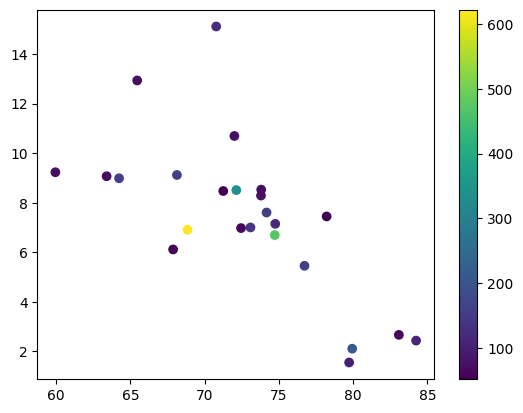

In [164]:
plt.scatter(complexes['mean'], complexes['std'], c=complexes['units'])
plt.colorbar()
plt.show()